In [12]:
import cv2

def deg2rad(deg):
    return (deg * pi) / 180.0

def rad2deg(rad):
    return (rad * 180.0) / pi

def draw_steering(img, x,y,r,theta):
    theta = -theta
    cv2.circle(img, (x, y), int(r), (255,0,0), 8)
    #cv2.line(img, (x,y), (x+int(r), y), (255,0,0), 8)    

    b=r*np.cos(theta)
    h=b*np.tan(theta)
    xp=x+int(b)
    yp=y-int(h)

    x1 = x - int(b)
    y1=y+int(h)

    cv2.line(img, (x1,y1), (xp,yp), (255,255,255), 8)

In [13]:
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE - tau_i * int_CTE
#
# where the integrated crosstrack error (int_CTE) is
# the sum of all the previous crosstrack errors.
# This term works to cancel out steering drift.
#
# Your code should print a list that looks just like
# the list shown in the video.
#
# Only modify code at the bottom!
# ------------
 
from math import *
import random


# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #    creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 1.):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    # --------
    # set_steering_drift: 
    #	sets the systematical steering drift parameter
    #

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res




    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)


In [14]:
############## ADD / MODIFY CODE BELOW ####################

# ------------------------------------------------------------------------
#
# run - does a single control run.


def run(param1, param2, param3):
    myrobot = robot()
    myrobot.set(0.0, 1.0, 0.0)
    speed = 1.0 # motion distance is equal to speed (we assume time = 1)
    N = 100
    #myrobot.set_steering_drift(10.0 / 180.0 * pi) # 10 degree bias, this will be added in by the move function, you do not need to add it below!
    #
    # Enter code here
    #
    
    int_cte = 0.0
    cte = myrobot.y
    
    for i in range(N):
        dcte = myrobot.y - cte
        cte = myrobot.y
        int_cte += cte
        steer = -param1 * cte - param2 * dcte - param3 * int_cte
        myrobot = myrobot.move(steer, speed)
        
        print( myrobot, steer )

# Call your function with parameters of (0.2, 3.0, and 0.004)
#run(0.2, 3.0, 0.04)

In [15]:
import numpy as np
import csv
import os

def load_simulator_data(csvfname):
    """
    Load dataset from csv file
    """
    data=[]
    with open(csvfname, 'r') as csvfile:
        data_tmp = list(csv.reader(csvfile, delimiter=','))
        for row in data_tmp:
            x7=[float(x) for x in row[7].split(':')]
            x8=[float(x) for x in row[8].split(':')]
            
            data.append(((row[0],row[1],row[2]),np.array([float(row[3]),float(row[4]),float(row[5]),float(row[6])]+x7+x8)))

    return data
filename='data/000/driving_log.csv'
position_data = load_simulator_data(filename)
len(position_data)

7684

In [16]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

def angle_trunc(a):
    """This maps all angles to a domain of [-pi, pi]"""
    while a < 0.0:
        a += pi * 2
    return ((a + pi) % (pi * 2)) - pi

def get_heading(car_position, target_position):
    """Returns the angle, in radians, between the target and hunter positions"""
    car_x, car_y = car_position
    target_x, target_y = target_position
    heading = atan2(target_y - car_y, target_x - car_x)
    heading = angle_trunc(heading)
    return heading


print([float(x) for x in "1239.393:754.3097:29.65825".split(":")])
print([position_data[0][1][4], position_data[0][1][5], position_data[0][1][6]])

[1239.393, 754.3097, 29.65825]
[1239.393, 754.30970000000002, 29.658249999999999]


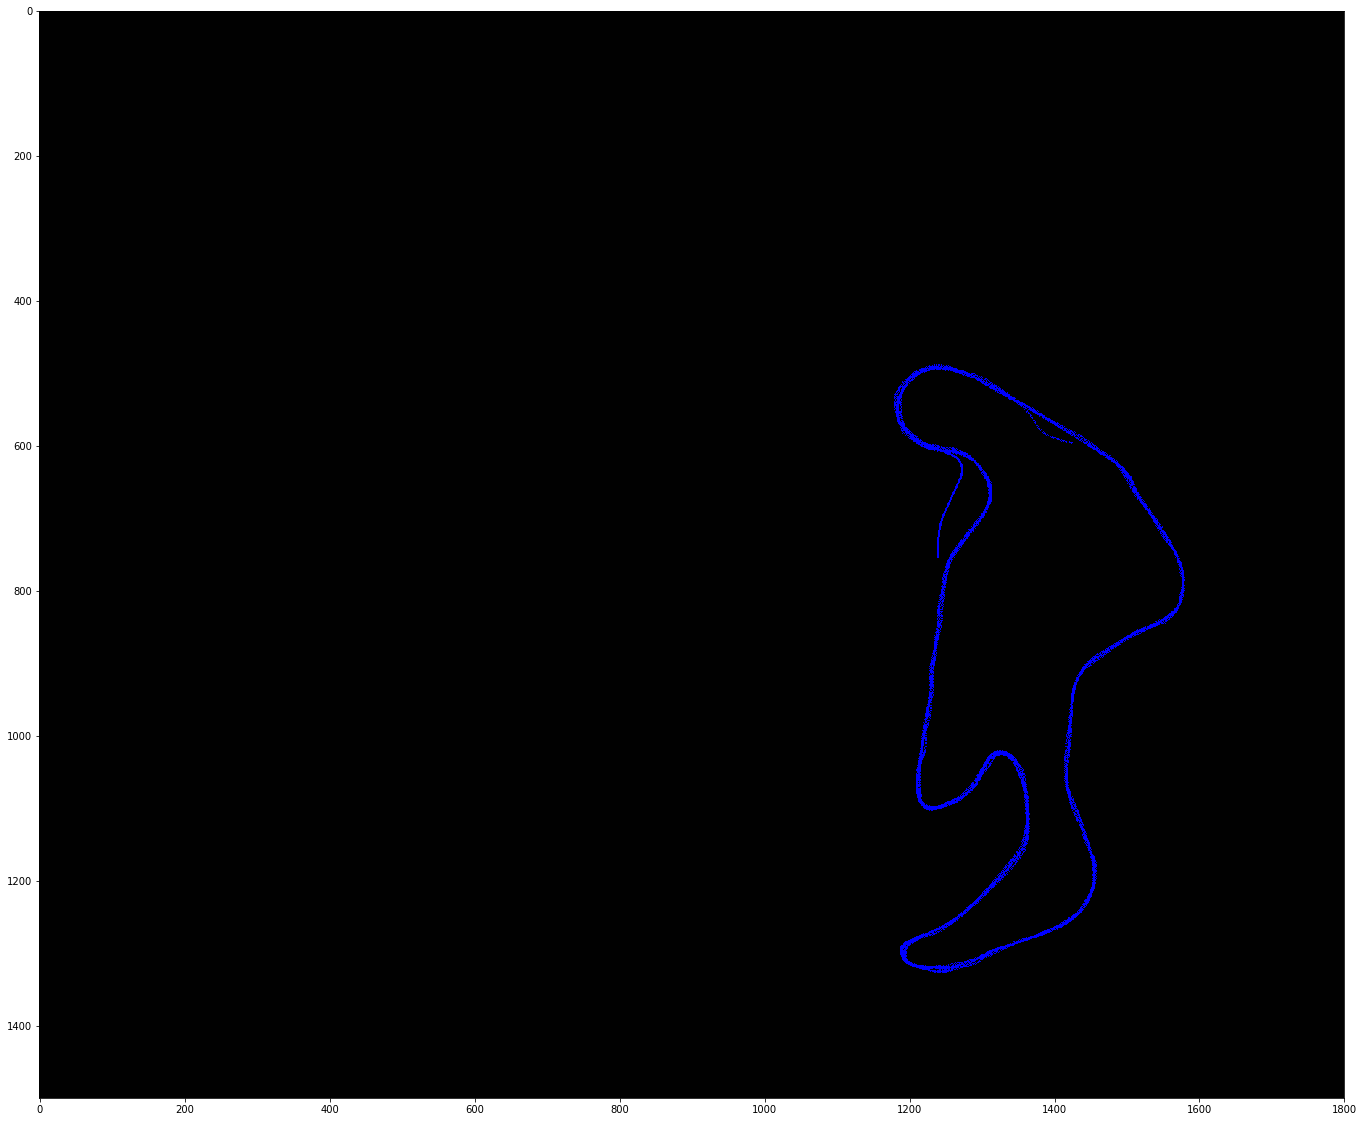

In [40]:
import cv2
img = np.ones((1500,1800, 3), np.uint8) 

#cv2.circle(img, (1240, 747), 3, (255,0,0), 3)
#cv2.circle(img, (1235, 865), 5, (255,0,0), 3)

keypoints = []

for idx, p in enumerate (position_data):
    pos = (int(p[1][4]), int(p[1][5]))
    cv2.circle(img,pos, 1, (0,0,255))
    if idx % 25 == 0:
        #cv2.circle(img, pos, 3, (255,255,0), 1)
        keypoints.append(pos)

plt.figure(figsize=(40,20))
plt.imshow(img)

In [18]:
#http://stackoverflow.com/questions/27461634/calculate-distance-between-a-point-and-a-line-segment-in-latitude-and-longitude
import math

def point_dist(x1,y1,x2,y2):
    return math.sqrt((x1-x2)*(x1-x2) + (y1-y2) * (y1-y2))

def dist(x1,y1, x2,y2, x3,y3): # x3,y3 is the point
    px = x2-x1
    py = y2-y1

    something = px*px + py*py
    
    if something == 0:
        return math.sqrt((x1-x3)*(x1-x3) + (y1-y3) * (y1-y3))

    u =  ((x3 - x1) * px + (y3 - y1) * py) / float(something)

    if u > 1:
        u = 1
    elif u < 0:
        u = 0

    x = x1 + u * px
    y = y1 + u * py

    dx = x - x3
    dy = y - y3

    dist = math.sqrt(dx*dx + dy*dy)

    return dist

def distance(p0, p1, p2): # p3 is the point
    x0, y0 = p0
    x1, y1 = p1
    x2, y2 = p2
    return dist(x0,y0,x1,y1, x2,y2)

def get_pos(p):
    return (int(p[1][4]), int(p[1][5]))

def get_steering(p):
    return float(p[1][0])

def get_rot_x(p):
    return float(p[1][7])

def get_rot_y(p):
    return float(p[1][8])

def get_rot_z(p):
    return float(p[1][9])

def get_speed(p):
    return float(p[1][3])


In [52]:
import imageio
imageio.plugins.ffmpeg.download()
import numpy as np
import moviepy.editor as mpy
import cv2

imgcp = img.copy()
maxp = len(position_data) - 25
r=150.
x=500
y=500

start = get_pos(position_data[0])
end = get_pos(position_data[1])
speed = get_speed(position_data[0])

car = robot()
car.set(start[0], start[1], deg2rad(-82.))
#print(rad2deg(car.orientation))

def get_cte(keypoints, cp):
    prev=keypoints[0]
    tp = (keypoints[0], keypoints[1])
    tpidx = 1
    mind = 1000.
    for idx, kp in enumerate(keypoints[1:]):
        d = distance(prev, kp, cp)
        if(mind>d):
            mind = d
            tp,tpidx = (prev, kp), idx
        prev = kp
    return mind, tp, tpidx

param1, param2, param3 = 0.2, 3.0, 0.04

int_cte = 0.0
cte = 0.0
dcte = 0.0
speed = 0.66
count = 0
tpidx = 1

def make_frame(t):
    global car, tpidx
    cp_img = np.copy(imgcp)
    cte, tp, tpidx = get_cte(keypoints[tpidx:], (car.x,car.y))
    cv2.line(cp_img,(int(car.x),int(car.y)), tp[1],  (255,255,255), 2)
    cv2.line(cp_img,tp[0], tp[1],  (255,255,255), 2)
    cv2.circle(cp_img, (int(car.x),int(car.y)), int(t % 5)+3, (255,0,0),3)    
    steer = get_heading((car.x, car.y), tp[1])
    steer = float(steer) % (2.0 * pi)
    steer = steer - car.orientation
    #steer = -param1 * cte - param2 * dcte - param3 * int_cte
    car = car.move(steer, speed)
    draw_steering(cp_img, 500,500,150,steer)
    cv2.putText(cp_img, str(rad2deg(steer))[:4], (300,300), cv2.FONT_HERSHEY_SIMPLEX, 4, (255,255,255), cv2.LINE_AA)
    return cp_img

duration=(int(maxp/24)+1) 
#duration = 60
clip = mpy.VideoClip(make_frame, duration=duration) # 2 seconds
clip.write_videofile("steering.mp4",fps=24, codec='mpeg4')
"""
cv2.circle(imgcp, (int(car.x),int(car.y)), 3, (255,0,255),3)    
cv2.line(imgcp,(int(car.x),int(car.y)), keypoints[5],  (255,255,255), 2)
steer = get_heading((car.x, car.y), keypoints[5]) 
steer = float(steer) % (2.0 * pi)
steer = steer - car.orientation

print(rad2deg(car.orientation), rad2deg(sr))

for x in range(50):
    car = car.move(steer, 1)
    cv2.circle(imgcp, (int(car.x),int(car.y)), 1, (255,0,0),1)    

plt.figure(figsize=(30,20))
plt.imshow(imgcp)
"""

[MoviePy] >>>> Building video steering.mp4
[MoviePy] Writing video steering.mp4


100%|█████████▉| 7680/7681 [02:23<00:00, 53.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: steering.mp4 



'\ncv2.circle(imgcp, (int(car.x),int(car.y)), 3, (255,0,255),3)    \ncv2.line(imgcp,(int(car.x),int(car.y)), keypoints[5],  (255,255,255), 2)\nsteer = get_heading((car.x, car.y), keypoints[5]) \nsteer = float(steer) % (2.0 * pi)\nsteer = steer - car.orientation\n\nprint(rad2deg(car.orientation), rad2deg(sr))\n\nfor x in range(50):\n    car = car.move(steer, 1)\n    cv2.circle(imgcp, (int(car.x),int(car.y)), 1, (255,0,0),1)    \n\nplt.figure(figsize=(30,20))\nplt.imshow(imgcp)\n'

In [35]:
print(dir(cv2.putText.__doc__))

['__add__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__iter__', '__le__', '__len__', '__lt__', '__mod__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmod__', '__rmul__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'capitalize', 'casefold', 'center', 'count', 'encode', 'endswith', 'expandtabs', 'find', 'format', 'format_map', 'index', 'isalnum', 'isalpha', 'isdecimal', 'isdigit', 'isidentifier', 'islower', 'isnumeric', 'isprintable', 'isspace', 'istitle', 'isupper', 'join', 'ljust', 'lower', 'lstrip', 'maketrans', 'partition', 'replace', 'rfind', 'rindex', 'rjust', 'rpartition', 'rsplit', 'rstrip', 'split', 'splitlines', 'startswith', 'strip', 'swapcase', 'title', 'translate', 'upper', 'zfill']


In [20]:
img = np.ones((1500,1800, 3), np.uint8) 
print(len(keypoints))
prev=keypoints[0]
for kp in keypoints[1:]:
    h = get_heading(prev, kp)
    print(h)
    prev = kp

308
-1.5707963267948966
-1.5707963267948966
-1.4940244355251187
-1.4382447944982228
-1.267911458419924
-1.1525719972156665
-1.1284221038181528
-1.1071487177940895
-1.3258176636680332
-1.4464413322481349
-1.9513027039072615
-2.4668517113662407
-2.761086276477428
-2.741351996555819
-2.4558631426835067
-1.833791058475816
-1.2597980461893563
-0.7641247773733859
-0.1651486774146278
0.28605144171731833
0.47646741947370685
0.5498531826765851
0.5532943253222928
0.5651494400067594
0.5624979310690725
0.6375487981386927
1.0303768265243125
0.9978301839061903
0.9888912086550112
1.1459641638755542
1.5935196876365376
2.3145519110937567
2.619189221873265
2.608748765970404
2.516107613350564
2.0749622882740493
1.698305885010135
1.633215136790854
1.5707963267948966
1.1902899496825317
1.2565644277105585
1.3909428270024184
1.7294515889812985
2.0940746489268722
2.4805494847391065
2.726100557648903
2.796945337971767
2.756435147226319
2.613518205163434
3.1058935409104693
-3.141592653589793
-2.6183143314578174